In [1]:
cfg_path = 'configs/cfg.yaml'
split = 'val'

In [2]:
import yaml
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch

from util import init_seed
from train import create_dataloader, load_model 

/anaconda/envs/tutorialenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/anaconda/envs/tutorialenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/tutorialenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resuming from epoch 53


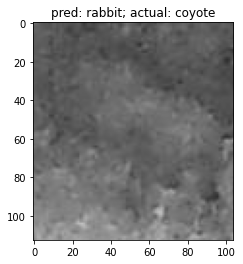

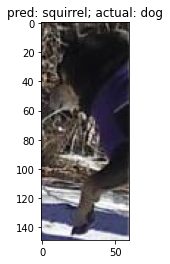

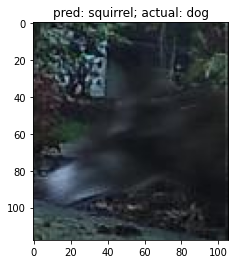

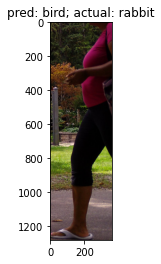

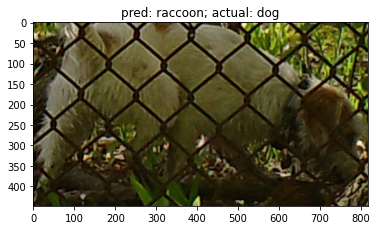

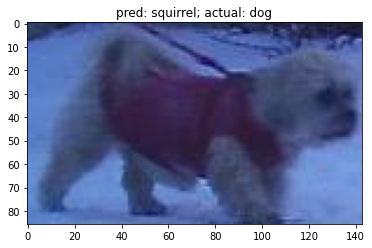

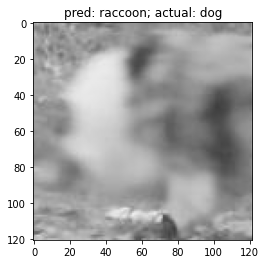

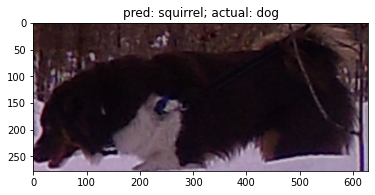

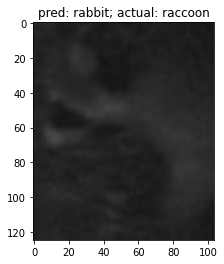

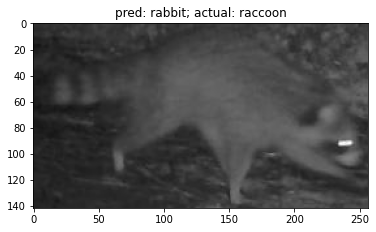

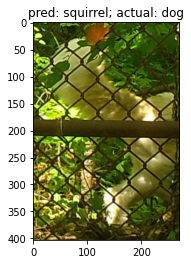

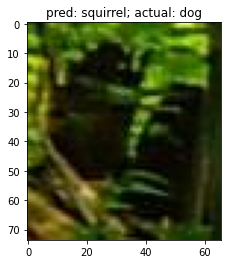

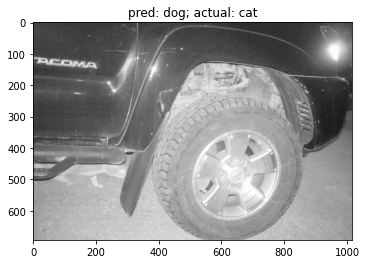

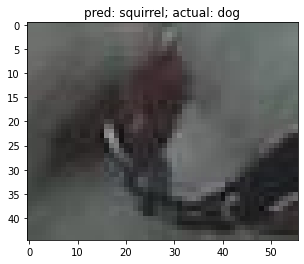

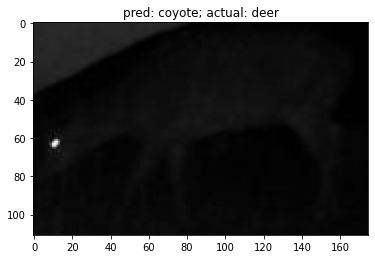

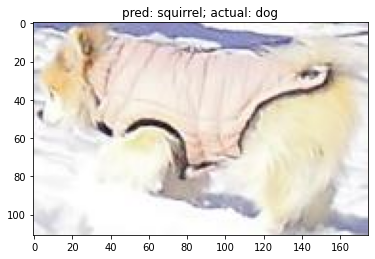

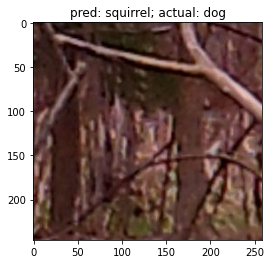

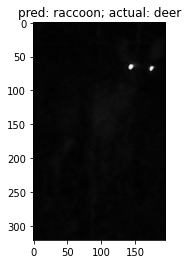

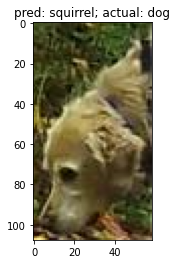

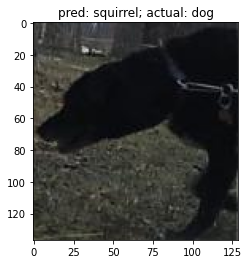

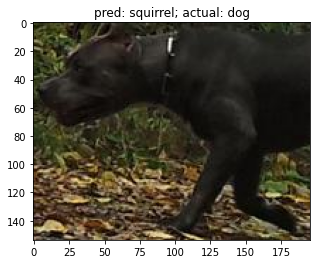

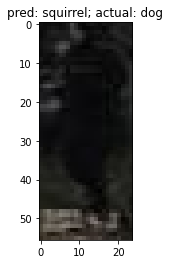

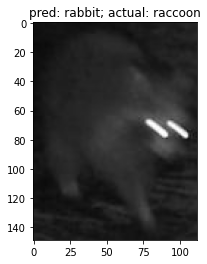

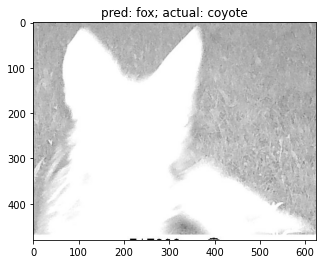

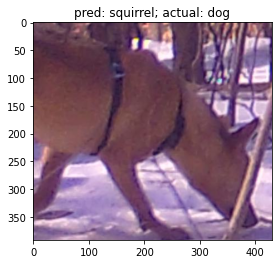

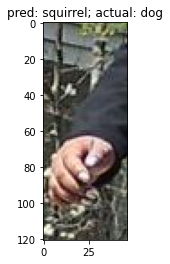

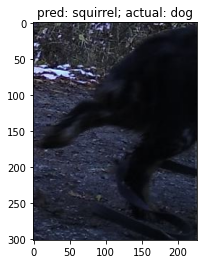

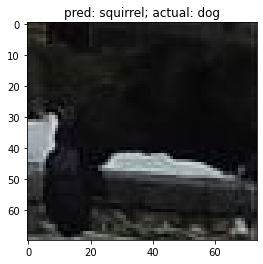

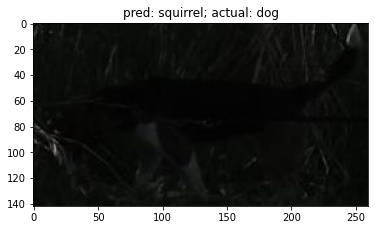

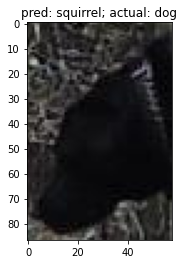

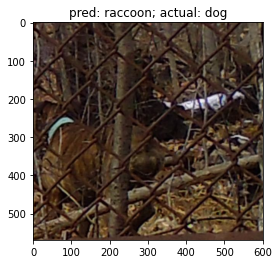

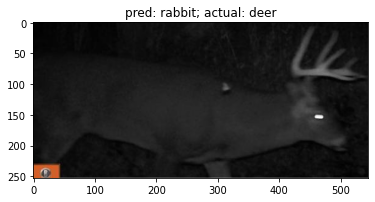

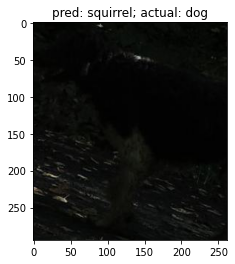

In [6]:
cfg = yaml.safe_load(open(cfg_path, 'r'))
cfg['model_dir'] = os.path.join('..', '..', cfg['model_dir'])
init_seed(cfg.get('seed', None))
device = cfg['device']
if device != 'cpu' and not torch.cuda.is_available():
    print(f'WARNING: device set to "{device}" but CUDA not available; falling back to CPU...')
    cfg['device'] = 'cpu'

dataLoader = create_dataloader(cfg, split=split)
classnames = dict([v,k] for k,v in dataLoader.dataset.species_to_index_mapping.items())
model, epoch = load_model(cfg)
model.to(device)

with torch.no_grad():
    for idx, (data, label, image_path) in enumerate(dataLoader):
        data = data.to(device)
        prediction = model(data)
        predict_label = torch.argmax(prediction.cpu(), dim=1)

        error = torch.nonzero(predict_label != label)

        for err in error:
            plt.figure()
            plt.imshow(Image.open(image_path[err]))
            plt.title(f'pred: {classnames[predict_label[err].item()]}; actual: {classnames[label[err].item()]}')
            plt.show()
        
        break